# IEEE SPS Seasonal School on Networked Federated Learning 
# https://ieeespcasfinland.github.io/
# Exericse 3

# Learning Goals 

After completing this exercise, you should 

* be able to store local datasets and local model parameters as node attributes of a `networkx.Graph` object 
* know how to learn model parameters using linear regression applied separately to each local dataset. 
* know about total variation (TV) regularization as a means to enforce similar model parameters for well-connected datasets (forming a "cluster").
* be able to derive the gradient descent steps for TV regularized linear regression.  

# Demo 3.1 - A Two-Cluster Toy Dataset

The code snippet below generates a `networkx.Graph` object `G` that represents a toy example for a networked dataset. Each node $i=0,\ldots,5$ of the `G` represents a local dataset. The nodes $i=0,1,2$ are connected by edges with large weights $A_{i,j}$. Similarily, also the nodes $i=3,4,5$ are connected by edges with large weights $A_{i,j}$. These two subsets (clusters) of nodes are connected by a single edge $\{2,3\}$ with small weight $A_{2,3}$. 

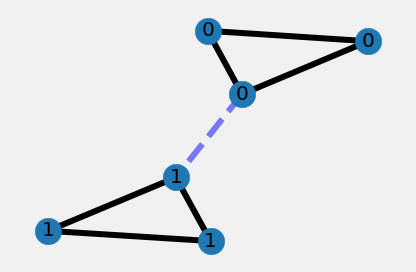

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()

G.add_nodes_from(range(6))  # add six nodes i=0,..,5 to the graph G. 

# assign nodes i=0,1,2 to block 0 

G.nodes[0]["block"] = 0 
G.nodes[1]["block"] = 0 
G.nodes[2]["block"] = 0 

# assign nodes i=3,4,5 to block 1

G.nodes[3]["block"] = 1
G.nodes[4]["block"] = 1 
G.nodes[5]["block"] = 1 


# add egdes (i,j) along with a weight A_ij 

#intra-cluster edges for block 0 
G.add_edge(0, 1, A=1)
G.add_edge(0, 2, A=1)
G.add_edge(1, 2, A=1)

#inter-cluster edge between block 0 and 1 
G.add_edge(2, 3, A=0.2)

# intra-cluster edges for block 1 
G.add_edge(3, 4, A=1)
G.add_edge(4, 5, A=1)
G.add_edge(3, 5, A=1)


# determine the edges whose weight is smaller than 1/2
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["A"] > 0.5]
# determine the edges whose weight is larger or equal than 1/2 
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["A"] <= 0.5]

# determine convenient coordinates for illustrating nodes in a plane
pos = nx.spring_layout(G, seed=7)  

# draw the nodes of the network 
nx.draw_networkx_nodes(G, pos, node_size=700)

# draw the edges with large weights using solid lines  
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)

# draw the edges with small weights using dashed lines 
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)


# draw the node names 
nx.draw_networkx_labels(G, pos, nx.get_node_attributes(G, 'block'), font_size=20, font_family="sans-serif")
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")

# make sure plot is displayed in the notebook 
plt.tight_layout()
plt.show()

## Adding Data and Model Parameters to Nodes of Toy Network

We have created a `networkx` object `G` with nodes $i=0,1,\ldots,5$ (stored in `G.nodes`) and some undirected edges $\{i,j\}$ (stored in `G.edges`) with weight $A_{i,j}$ (stored in edge attribute "A"). The code snippet below adds a local dataset and a weight vector to each node of `G`. 

The local dataset of node $i$ consists of several datapoints.  The $r$-th data point assigned to node `i` is characterized by a numeric feature vector $\mathbf{x}^{(i,r)} \in \mathbb{R}^{n}$ and a numeric label value $y^{(i,r)}$. We collect the feature vectors and label values into the feature matrix 
$$\mathbf{X}^{(i)} = \big(\mathbf{x}^{(i,1)},\ldots,\mathbf{x}^{(i,m_{i})} \big)^{T} \mbox{ , and } \mathbf{y}^{(i)} = \big(y^{(i,1)},\ldots,y^{(i,m_{i})} \big)^{T}.$$

For each node of `G`, we add the attributes `X` and `y` which store the feature matrix $\mathbf{X}^{(i)}$ and label vector $\mathbf{y}$, respectively. Beside the local dataset (given by $\mathbf{X}^{(i)}$ and $\mathbf{y}$), we also assign a weight vector $\mathbf{w}^{(i)}$ to each node $i$. This weight vector will be stored in the node attribute `w` and defines a local ("personalized") hypothesis $h^{(i)}(\mathbf{x}) = \big( \mathbf{w}^{(i)} \big)^{T} \mathbf{x}$. We can use the hypothesis $h^{(i)}$ to predict the label of a data point based on its features: $y \approx h^{(i)}(\mathbf{x}) = \big( \mathbf{w}^{(i)} \big)^{T} \mathbf{x}$. 

In [12]:
import numpy as np 

samplesize=10 # use same size m_{i} = samplesize for each local dataset


# generate one true weight vector for each block 
true_weights = np.random.randn(2,2)

# define the noise std. deviation 
noisestrength = 0.1
    
for iter_node in G.nodes: 
# create a feature matrix whose rows contain the feature vectors of individual data points 
# each data point is characterized by a feature vector (x1,x2) of lenght 2. The first feature 
# x1 is an arbitrary number while the second feature x2 is fixed to be always equal to 1 (a "dummy feature")
   X = np.hstack((np.random.randn(samplesize,1),np.ones((samplesize,1))))
# choose the true weight vector for the block to which the node belongs to
   true_w = true_weights[:,G.nodes[iter_node]["block"]]
# create synthetic labels of data points and store them as the entries of the numpy array y 
   y = X.dot(true_w) + noisestrength*np.random.randn(samplesize,)
    
   # the node attribute "X" stores the feature vectors of the data points associated with a node 
   G.nodes[iter_node]["X"] = X 

   # the node attribute "y" stores the labels for the data points of associated with a node 
   G.nodes[iter_node]["y"] = y 
   
   # the node attribute "w" stores the weight vector of a linear hypothesis 
   # note that each node might have a potentially different weight vector (personalized model!)  

   G.nodes[iter_node]["w"] = np.zeros(X.shape[1]) # initialize weights at node "iter_node" to zeros

# Demo 3.2 - Gradient Descent for Total Variation Minimization

Let us now develop a simple but useful distributed algorithm for learning the local weights $\mathbf{w}^{(i)}$ assigned to the nodes of `G`. Like in Exercise 1, we will use the squared error loss measure to evaluate the quality of a particular choice for $\mathbf{w}^{(i)}$. We then obtain the average squared error at node $i$ as 
$ (1/m_{i}) \big\| \mathbf{y}^{(i)} - \mathbf{X}^{(i)} \mathbf{w}^{(i)} \big\|^{2}_{2} $. 

In principle we could learn the weight vectors $\mathbf{w}^{(i)}$ separately by minimizing the respective average squared error at each node. However, we should also exploit the information conveyed by the edges and their weights in the empirical graph `G`. Informally, we require the weight vectors $\mathbf{w}^{(i)}$ and $\mathbf{w}^{(j)}$ at two nodes that are connected by an edge with a large weight to be close to each other. This requirement is made precise by the following total variation minimization problem: 
\begin{equation}
\min_{\mathbf{w}^{(0)},\ldots,} \sum_{i} (1/m_{i}) \big\| \mathbf{y}^{(i)} - \mathbf{X}^{(i)} \mathbf{w}^{(i)} \big\|^{2}_{2}
+ \lambda_{\rm TV} \sum_{\{i,j\}} A_{i,j} \| \mathbf{w}^{(i)} - \mathbf{w}^{(j)} \|^{2}_{2}. \quad \quad {\rm (TVMin)}
\end{equation} 
Note that (TVMin) is a special case of the optimization problem in [2, Eq. 1]. 

Note that (TVMin) amounts to minimizing a smooth and convex objective function 
$$ f(\mathbf{w}) = \sum_{i} (1/m_{i}) \| \mathbf{y}^{(i)} - \mathbf{X}^{(i)} \mathbf{w}^{(i)} \|^{2}_{2}
+ \lambda_{\rm TV} \sum_{\{i,j\}} A_{i,j} \| \mathbf{w}^{(i)} - \mathbf{w}^{(j)} \|^{2}_{2}.$$ 
The optimization variable $\mathbf{w} = \big( \big(\mathbf{w}^{(0)}\big)^{T},\ldots, \big(\mathbf{w}^{(m-1)}\big)^{T} \big)^{T}$ is the vector obtained by stacking the local weight vectors. 

As discussed in Exercise 1, we can iteratively minimize a smooth and convex function by GD steps: 
\begin{align} 
\mathbf{w}^{(k+1)} & = \mathbf{w}^{(k)} - \alpha \nabla f\big(\mathbf{w}^{(k)}\big)  \quad \quad \mbox{ (Generic GD)}. 
\end{align}
The gradient $f\big(\mathbf{w}\big)$ can be shown to be given as (see, e.g., [1, Appendix A.4]) 
$$\nabla f\big(\mathbf{w} \big) = \big( \big( \mathbf{g}^{(1)}\big)^{T},\ldots,\big(\mathbf{g}^{(m-1)}\big)^{T} \big)^{T} \mbox{ , with } \mathbf{g}^{(i)} = - (2/m_{i}) \big( \mathbf{X}^{(i)} \big)^{T}\big( \mathbf{y}^{(i)} - \mathbf{X}^{(i)} \mathbf{w}^{(i)} \big)+ 2 \sum_{i' \neq i } A_{i,i'} \big( \mathbf{w}^{(i)} - \mathbf{w}^{(i')} \big).  \quad {\rm (GradientTV)}.$$
Inserting (GradientTV) into (Generic GD) results in the following local update rule for the $k$-th iteration of GD at node $i$, 
\begin{align} 
\mathbf{w}^{(i,k+1)} & = \mathbf{w}^{(i,k)} - \alpha \left(- (2/m_{i}) \big( \mathbf{X}^{(i)} \big)^{T}\big( \mathbf{y}^{(i)} - \mathbf{X}^{(i)} \mathbf{w}^{(i,k)} \big)+ 2 \sum_{i' \neq i } A_{i,i'} \big( \mathbf{w}^{(i,k)} - \mathbf{w}^{(i',k)} \big) \right)  \quad \quad \mbox{ (GDTVMin)}.
\end{align}
Note that the update (GDTVMin), which is carried out simultaneously at all nodes of `G`, requires only local information for each node. In particular, to compute (GDTVMin) at node `i`, we need the current weight vector $\mathbf{w}^{(i,k)}$ stored at node $i$ and the current weight vectors stored at the neighbors $\mathcal{N}(i)$ of node $i$. 

[1] S. Boyd and L. Vandenberghe, "Convex Optimization", Cambridge University Press, 2004 [available here](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf)

[2] V. Smith, C.-K. Chiang, M. Sanjabi and A. Talwalkar, “Federated Multi-Task Learning”, <i>arXiv e-prints</i>, 2017. https://arxiv.org/pdf/1705.10467.pdf 



In [13]:
N_GD  = 1000 # number of GD steps. 

lambda_TV = 1


# set the learning rate alpha for the (GDTVMin) update 

learning_rate = 1/(2*len(G.nodes)+lambda_TV*6)

# initialize the weight vector for each local hypothesis to be all zero
for node_i in G.nodes(data=False): 
    G.nodes[node_i]["w"] = np.zeros(X.shape[1]) 

# repeat the GD step in (GDTVMin) for a total of N_GD times
for iter_GD in range(N_GD):
    for node_i in G.nodes(data=False): 
        X = G.nodes[node_i]["X"] 
        y = G.nodes[node_i]["y"]
        # compute local gradient g for current weight vector at node iter_node
        # start with the gradient contribution from the training error \|y - X*w\|^{2}_{2} 
        tmp =  -(2/samplesize) *(X.T.dot(y - X.dot(G.nodes[node_i]["w"]))) 
        # now add the gradient contribution from the total variation term 
        # loop over all neighbours of current node "node_i"
        for node_j in G[node_i]: 
            edge_weight = float(G.edges[(node_i,node_j)]["A"])
            tmp  =  tmp + 2*lambda_TV*edge_weight*(G.nodes[node_i]["w"]- G.nodes[node_j]["w"] )
        G.nodes[node_i]["g"] = tmp
    
    # the following loop over all nodes, implements a separate GD step (GDTVMin) 
    # to update the weight vector at each node 
    for node_i in G.nodes(data=False):
        G.nodes[node_i]["w"] = G.nodes[node_i]["w"] - (learning_rate * G.nodes[node_i]["g"] )
        
print("True weights of block 0:\n",true_weights[:,0],'\n')
print("True weights of block 1:\n",true_weights[:,1],'\n')
for node in G.nodes(data=False): 
    print("Learnt weights at node",node," : ",G.nodes[node]["w"],"\n")

True weights of block 0:
 [0.99323947 0.14769641] 

True weights of block 1:
 [-0.10770125  0.73958058] 

Learnt weights at node 0  :  [0.89864078 0.15645256] 

Learnt weights at node 1  :  [0.92406295 0.15511464] 

Learnt weights at node 2  :  [0.85674885 0.19988398] 

Learnt weights at node 3  :  [-0.01074377  0.66975689] 

Learnt weights at node 4  :  [-0.05232259  0.71750828] 

Learnt weights at node 5  :  [-0.05561108  0.71018204] 



The code snippet below creates a separate sub-plot for each node $i$ of the empirical graph `G`. The $i$-th subplot contains the datapoints assigned to a network node $i$ along with the linear predictor learnt for this node. 

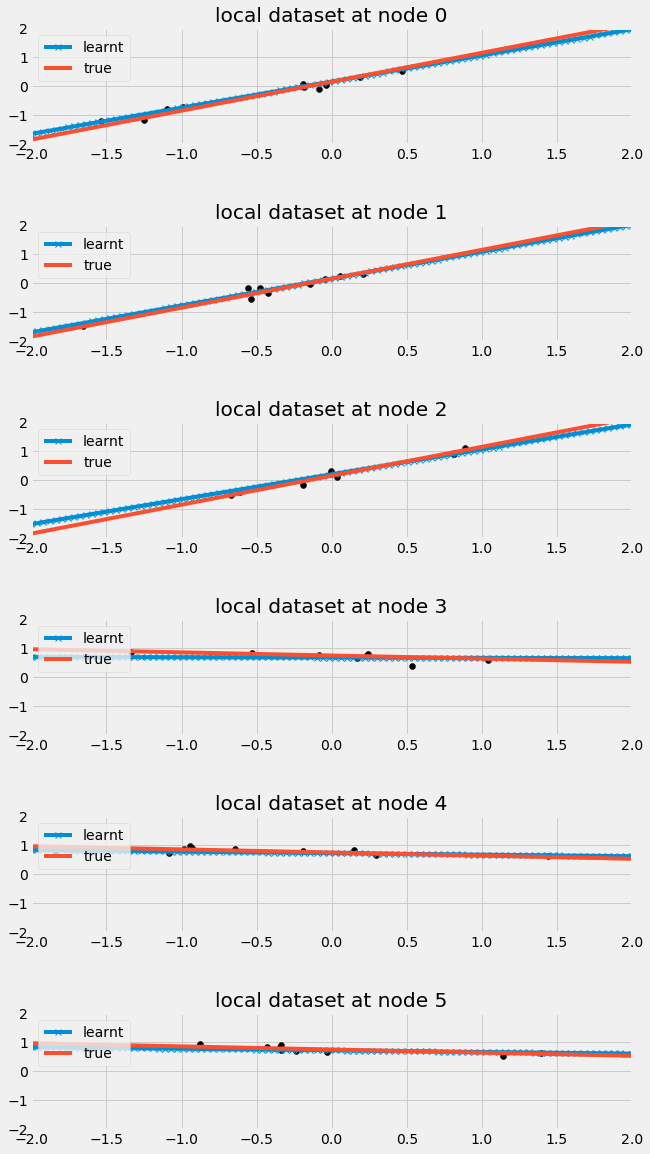

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(G.nodes),figsize=(10,17))
plt.style.use('fivethirtyeight')
    
X_grid = np.hstack((np.linspace(-2.0, 2.0, 100).reshape(-1,1),np.ones((100,1))))

for iter_node in G.nodes: 
    X = G.nodes[iter_node]["X"]
    y = G.nodes[iter_node]["y"]
    learnt_weights = G.nodes[iter_node]["w"]
    txt="local dataset at node "+str(iter_node)
    axs[iter_node].set_ylim([-2, 2])
    axs[iter_node].set_xlim([-2, 2])
    axs[iter_node].title.set_text(txt)
    axs[iter_node].scatter(X[:,0], y, color='black')
    
    # illustrate the learnt weights by a straight line obtained by evaluating the 
    # corresponding linear predictor for a regular grid of feature values X_grid
    axs[iter_node].plot(X_grid[:,0], X_grid.dot(learnt_weights),marker="x",label = "learnt")
    
    # illustrate the optimal predictor obtained from the ground truth weight vector
    axs[iter_node].plot(X_grid[:,0], X_grid.dot(true_weights[:,G.nodes[iter_node]["block"]]), label ="true")
    axs[iter_node].legend(loc='upper left')

plt.tight_layout(pad=3.0)
plt.show()

# Task 3.1

* Experiment with different choices for the inter-cluster edge weigtt `G[(2,3)]["A"]` in Demo 3.1. What is the effect on the results obtained from Demo 3.2. when making this weight smaller or larger. 

* Experiment with different choices for the regularization parameter `lambda_TV` in Demo 3.2.  What is the effect on the local weight vectors obtained from Demo 3.2. when making this parameter smaller (extreme case 0) or larger. 

# Task 3.2

Modify Demo 3.2. by replacing the synthetic dataset (obtained from Demo 3.1) with the networked weather dataset `G_FMI` generated in Demo 2.4.